In [1]:
using CSV, DataFrames, Statistics
using PyPlot # plotting library
using PyCall
using Printf
using FStrings
using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"

# check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("seaborn-pastel")

# change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

#make jupyter notebook print more dataframe columns
ENV["COLUMNS"]=160
hand = "2v2"

print("Ready to go!")

Ready to go!

-----

# Reading in the Data
Now reading in the metrics data for 2v2.

In [101]:
df_2v2 = CSV.read("results/2v2_metrics.csv", DataFrame, copycols=true)
first(df_2v2, 23)

,trial,arc_len,area_btwn,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,sub1_2v2_a_n_1,0.915118,0.0210593,0.9,0.00490139,0.0276,0.402884,4.903,0.0277119
2,sub1_2v2_a_n_2,0.7148,0.0241181,0.9,0.00206908,0.0188,0.508725,8.6598,0.0194225
3,sub1_2v2_a_n_3,1.28018,0.0384869,0.9,0.00662867,0.0194,0.276161,6.2054,0.0429625
4,sub1_2v2_a_n_4,0.697772,0.0197627,0.9,0.00369012,0.0094,0.55733,4.5364,0.0268033
5,sub1_2v2_a_n_5,0.819163,0.0244863,0.9,0.00395754,0.0359,0.474739,6.4339,0.035901
6,sub2_2v2_a_n_1,0.67969,0.0111813,0.91,0.00220399,0.0153,0.460697,5.7871,0.0210955
7,sub2_2v2_a_n_2,1.16322,0.0402499,0.91,0.00261126,0.0329,0.199724,6.382,0.146714
8,sub2_2v2_a_n_3,1.03924,0.0401208,0.9,0.00178644,0.0224,0.247849,6.2749,0.092246
9,sub2_2v2_a_n_4,0.717419,0.0157235,0.89,0.00340992,0.0365,0.457589,5.0463,0.039268


In [102]:
subject_nums = []
translations = []
numbers = []

for row in eachrow(df_2v2)
    x = row[:trial]
    push!(subject_nums, x[4])
    push!(translations, x[10])
    push!(numbers, x[14])
end

s = convert(Array{Char,1}, subject_nums)
d = convert(Array{Char,1}, translations)
n = convert(Array{Char,1}, numbers)

insertcols!(df_2v2, 2, :subj=>s)
insertcols!(df_2v2, 3, :dir=>d)
insertcols!(df_2v2, 4, :num=>n)
first(df_2v2, 17)

,trial,subj,dir,num,arc_len,area_btwn,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Char,Char,Char,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,sub1_2v2_a_n_1,1,a,1,0.915118,0.0210593,0.9,0.00490139,0.0276,0.402884,4.903,0.0277119
2,sub1_2v2_a_n_2,1,a,2,0.7148,0.0241181,0.9,0.00206908,0.0188,0.508725,8.6598,0.0194225
3,sub1_2v2_a_n_3,1,a,3,1.28018,0.0384869,0.9,0.00662867,0.0194,0.276161,6.2054,0.0429625
4,sub1_2v2_a_n_4,1,a,4,0.697772,0.0197627,0.9,0.00369012,0.0094,0.55733,4.5364,0.0268033
5,sub1_2v2_a_n_5,1,a,5,0.819163,0.0244863,0.9,0.00395754,0.0359,0.474739,6.4339,0.035901
6,sub2_2v2_a_n_1,2,a,1,0.67969,0.0111813,0.91,0.00220399,0.0153,0.460697,5.7871,0.0210955
7,sub2_2v2_a_n_2,2,a,2,1.16322,0.0402499,0.91,0.00261126,0.0329,0.199724,6.382,0.146714
8,sub2_2v2_a_n_3,2,a,3,1.03924,0.0401208,0.9,0.00178644,0.0224,0.247849,6.2749,0.092246
9,sub2_2v2_a_n_4,2,a,4,0.717419,0.0157235,0.89,0.00340992,0.0365,0.457589,5.0463,0.039268


## Asterisk Plot

![Avg Asterisk](./pics/avgd_2v2_3subs_n.jpg)

-----

# Histograms of Metrics
Now I will produce histogram plots of the metrics to see what kind of a distribution we get for all the trials.
Shamelessly taken from my previous datascience course at: [link](https://github.com/SimonEnsemble/data_science_course)

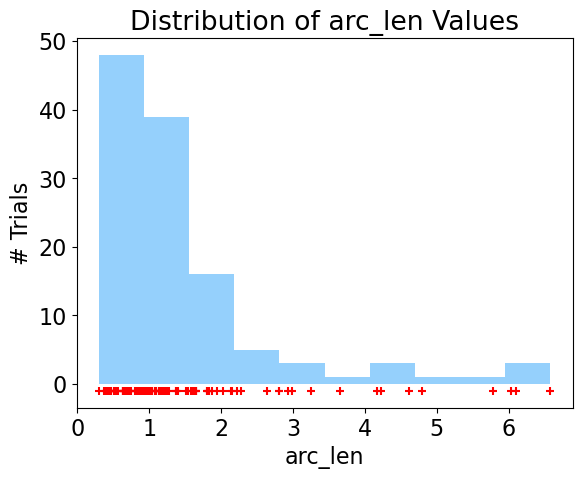

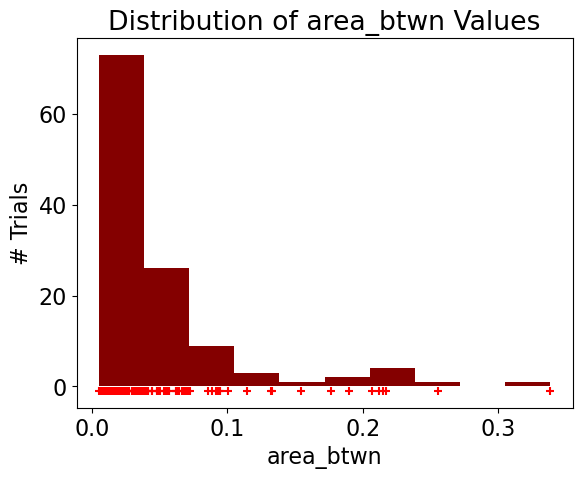

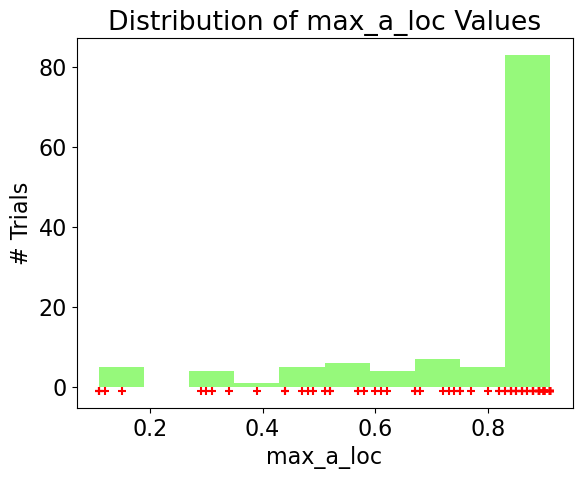

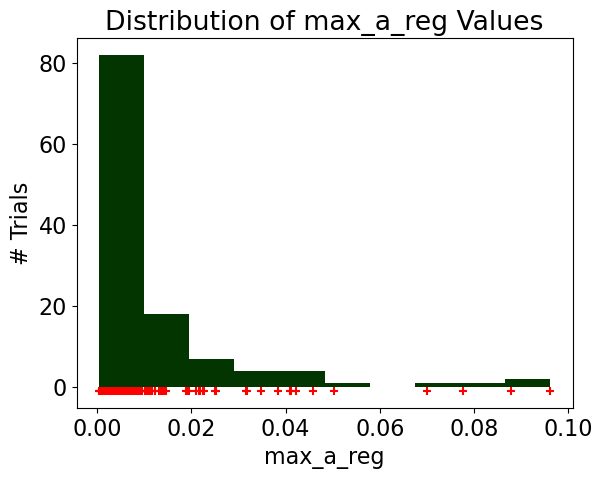

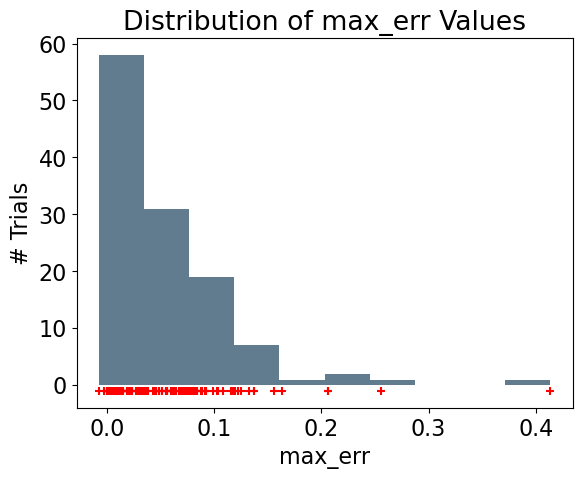

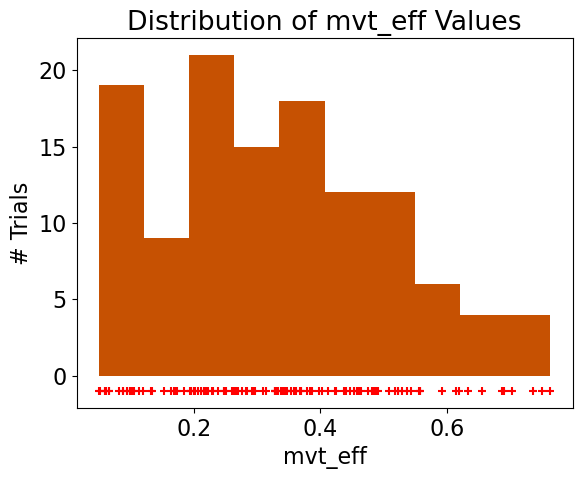

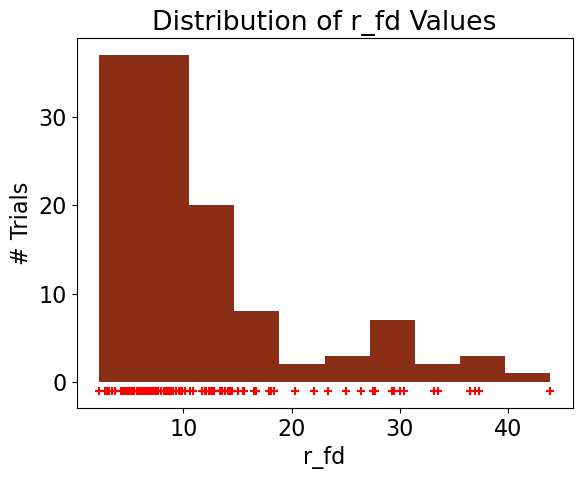

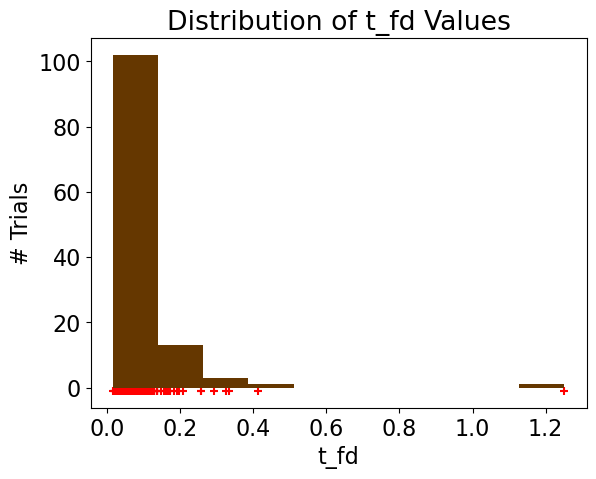

In [3]:
metrics = [:arc_len, :area_btwn, :max_a_loc, :max_a_reg, :max_err, :mvt_eff, :r_fd, :t_fd]

plot_colors = ["xkcd:light blue", "xkcd:dark red", "xkcd:light green", "xkcd:dark green",
               "xkcd:blue grey", "xkcd:dark orange", "xkcd:red brown", "xkcd:brown"]

i = 1
for m in metrics
    figure()
    hist(df_2v2[:, m], color=plot_colors[i]) #, normed=true)
    scatter(df_2v2[:, m], [-1 for i = 1:nrow(df_2v2)], marker="+", color="r")
    xlabel(f"{m}")
    ylabel("# Trials")
    title(f"Distribution of {m} Values")
    i = i + 1
end

### Observations of Histogram Plots
Based on what I see, here are the observations per metric (in order of appearance top to down):
* **arc length**: mostly concentrated at low arc lengths
* **max area region location**: mostly, the region of max error area is most commonly found at the end
* **max area region**: at the locations of max error area, the area of error (aka the area between the path and the target line) is still relatively low
* **max error**: values are distributed
* **movement efficiency**: values are distributed
* **rotational frechet distance**: aka max rotation error. Mostly low, but larger distribution at the low end
* translational frechet distance: all values are very low

----

# Metric Values by direction
Plot all metric values in bar charts by direction

In [31]:
subjects = ["sub1", "sub2", "sub3"]
translations = ["a", "b", "c", "d", "e", "f", "g", "h"]
rotations = ["n"]

function get_trial_vals(df::DataFrame, metric::Symbol, translation::String)
    hand = "2v2"
    subjects = ["sub1", "sub2", "sub3"]
    numbers = ["1", "2", "3", "4", "5"]
    
    values = []
    names = []
    
    for s in subjects
        for n in numbers
            trial_name = f"{s}_{hand}_{translation}_n_{n}"
            plot_name = f"{s}_{n}"
            row = df[df[!, :trial] .== trial_name, :]
            val = row[!, metric][1]
            
            push!(values, val)
            push!(names, plot_name)
        end
    end
    v = convert(Array{Float64,1}, values)
    #print(v)
    
    return v, names
end


function plt_metric_and_directions(m::Symbol, c::String="nothing")
    
    for t in translations
        figure()
        plt_title = f"{hand}: {m} - {t}_n"
        values, names = get_trial_vals(df_2v2, m, t)

        if c == "nothing"
            bar(names, values)
        else
            bar(names, values, color=c)
        end
        xticks(rotation=-45, ha="left")
        title(plt_title)
    end
end

print("Functions are ready!")

Functions are ready!

### Arc Length


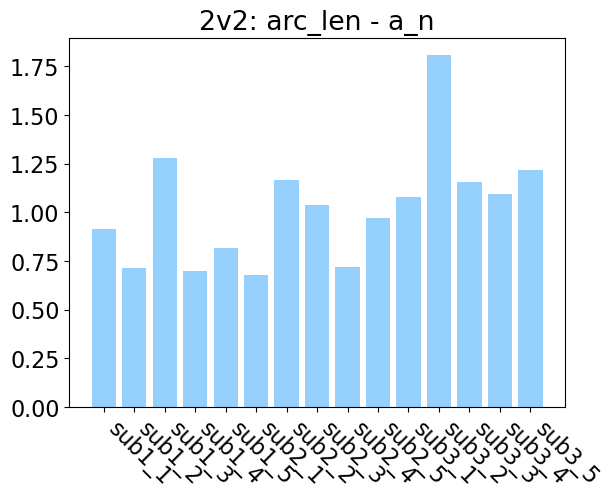

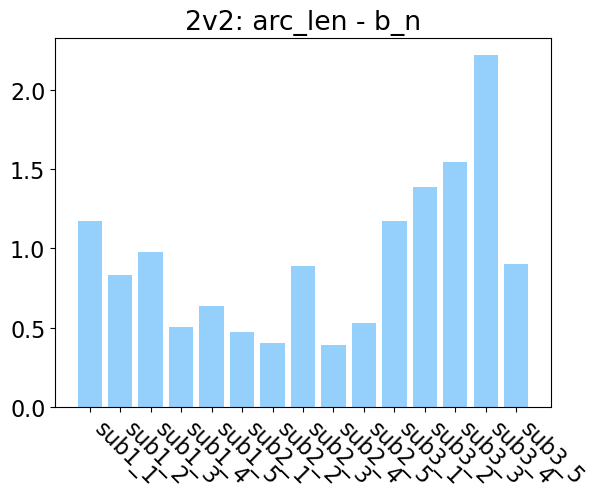

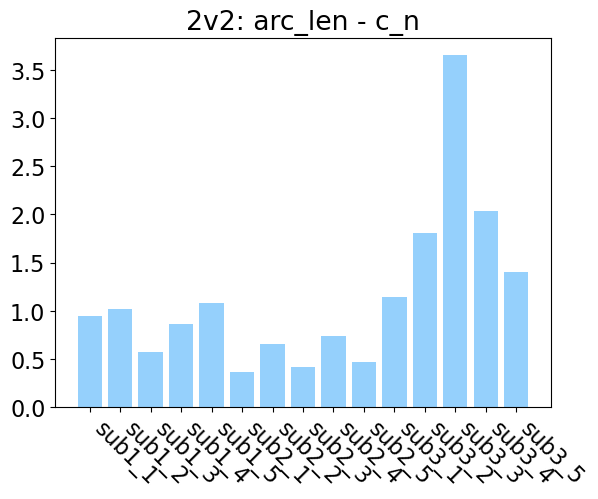

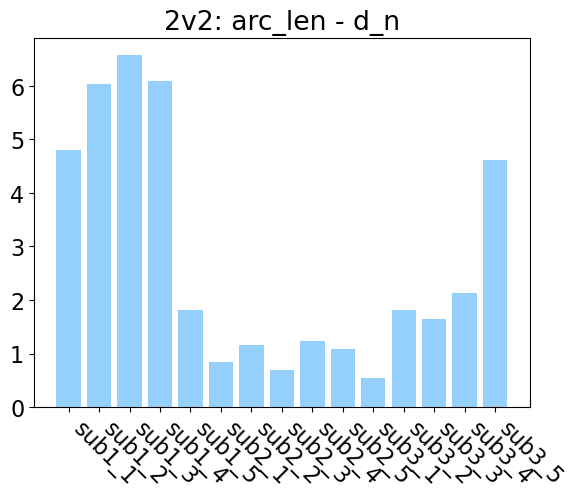

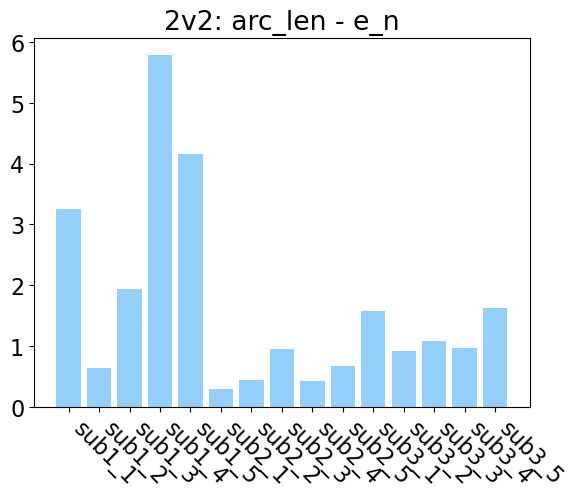

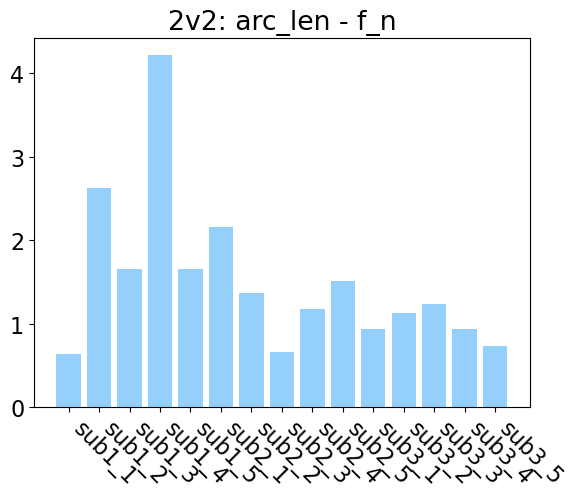

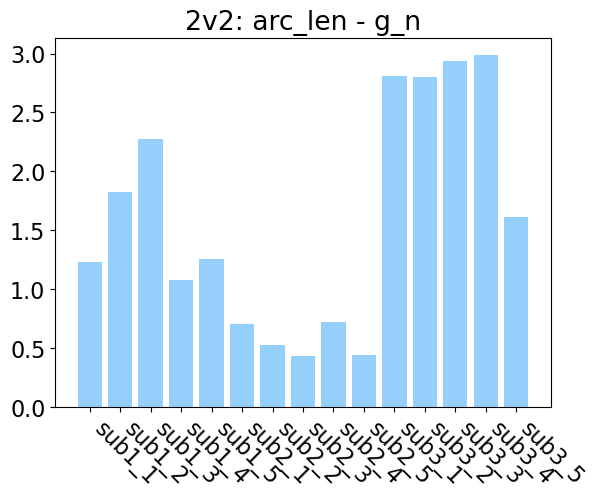

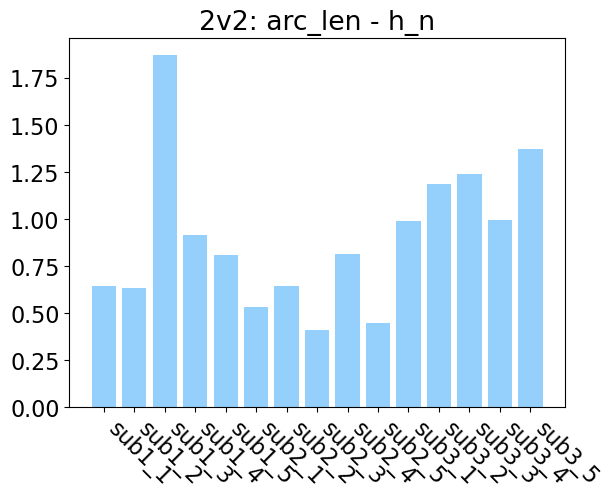

In [5]:
plt_metric_and_directions(:arc_len, "xkcd:light blue")

### area_btwn

metrics = [:arc_len, :area_btwn, :max_a_loc, :max_a_reg, :max_err, :mvt_eff, :r_fd, :t_fd]

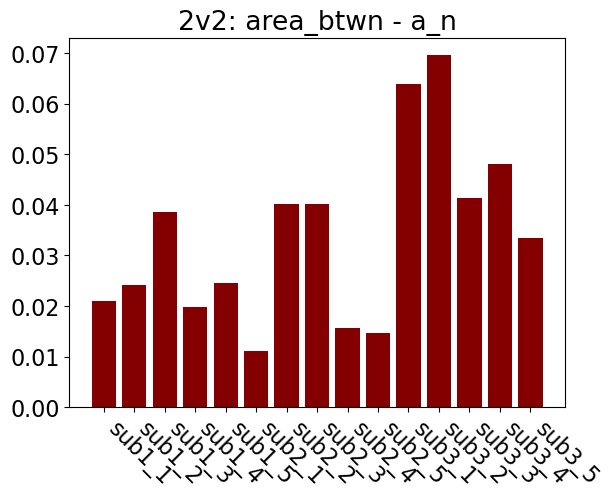

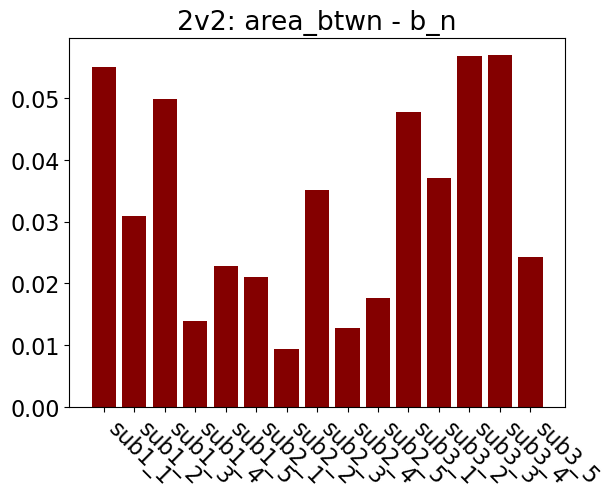

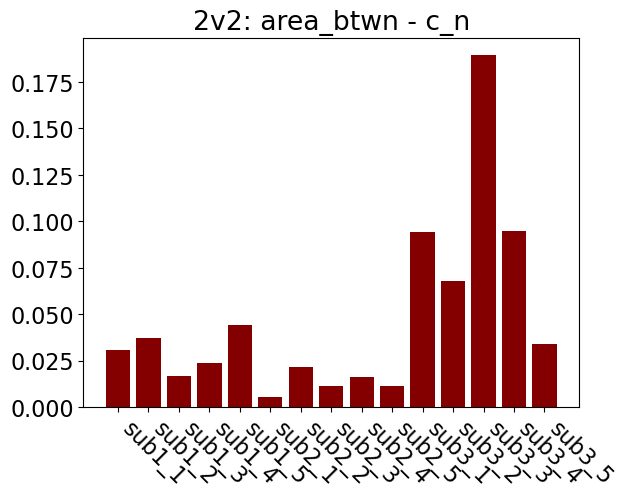

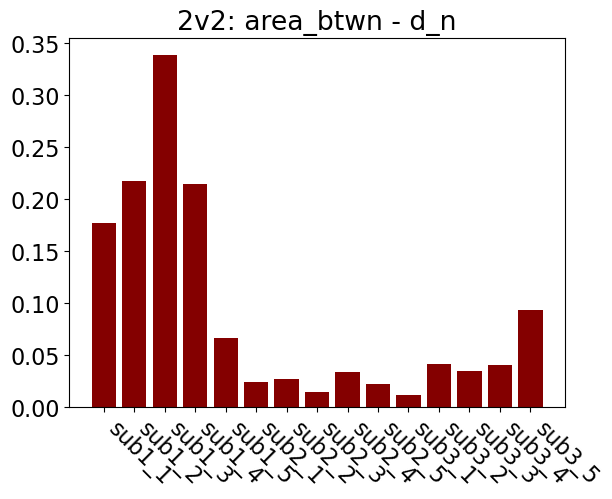

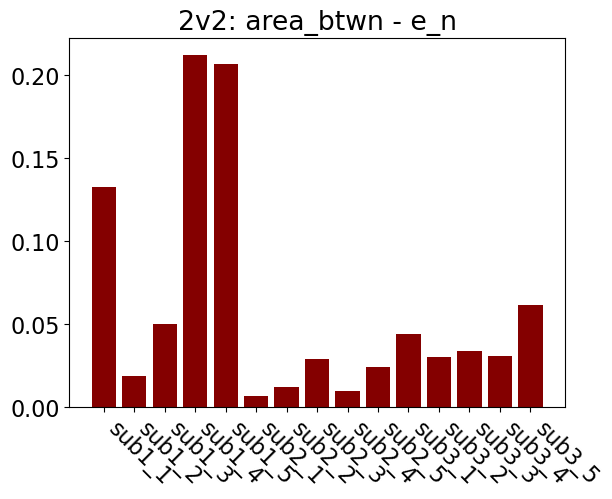

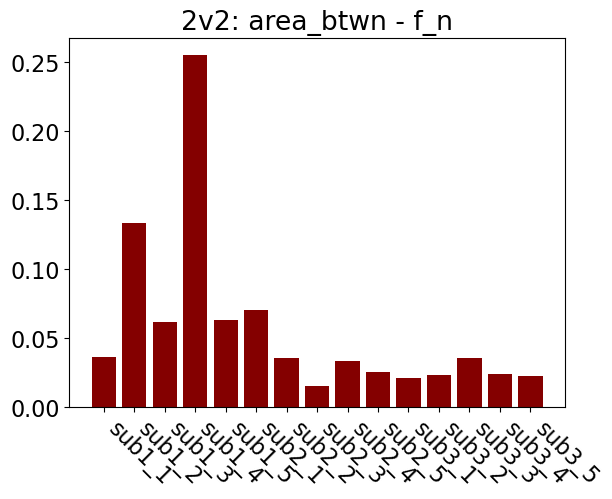

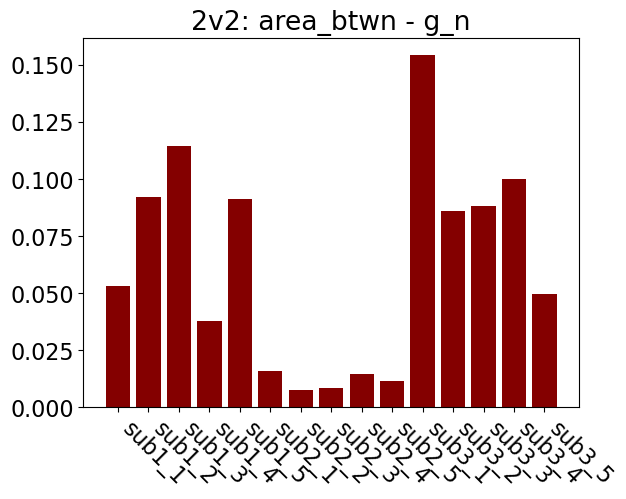

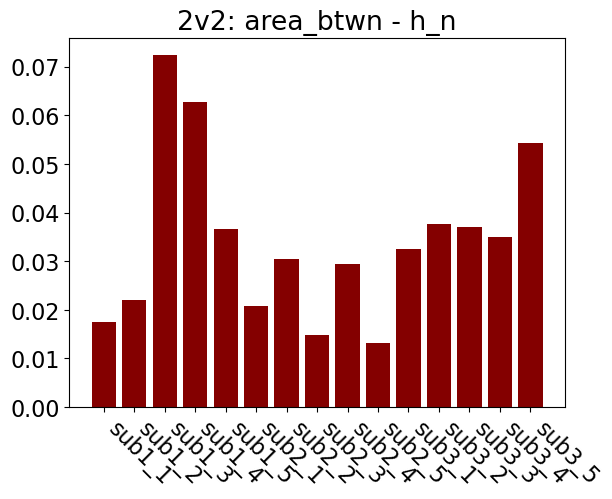

In [6]:
plt_metric_and_directions(:area_btwn, "xkcd:dark red")

### Max error


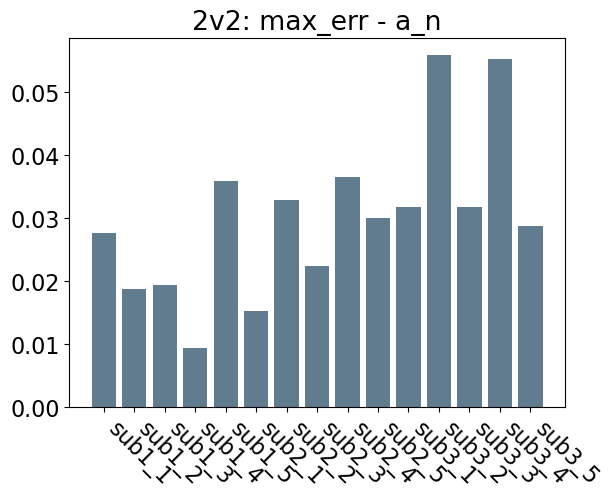

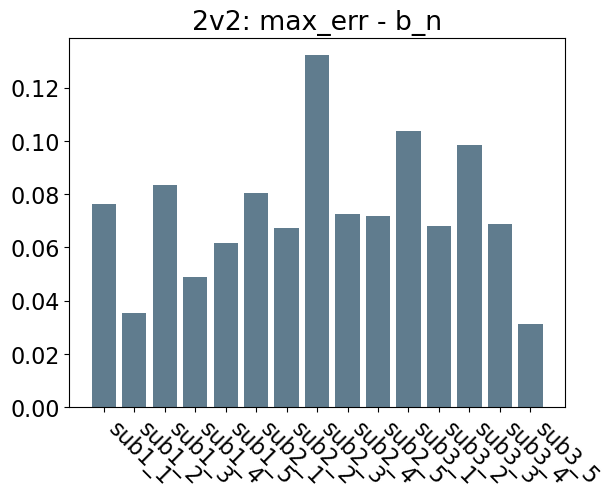

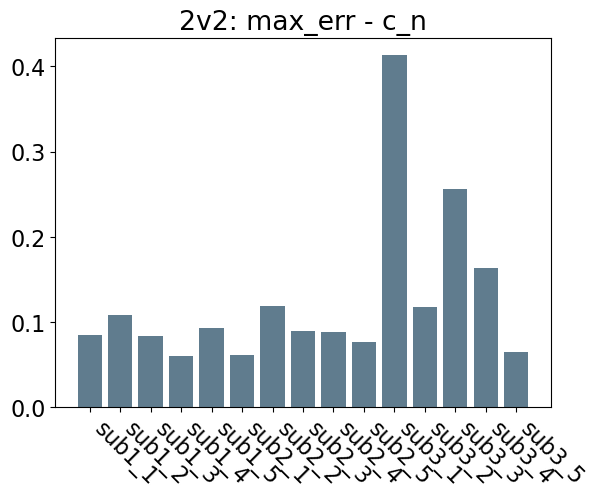

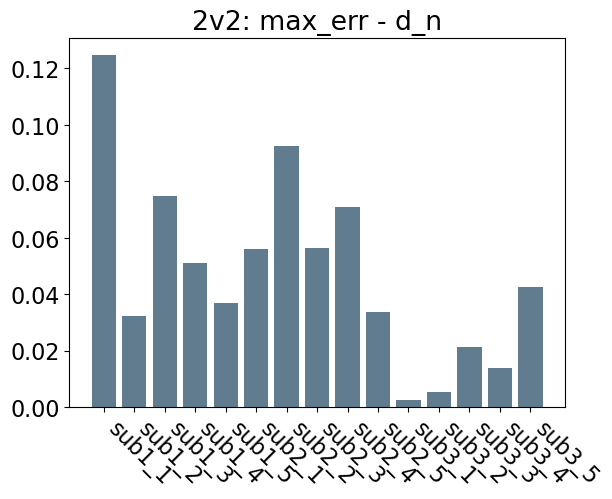

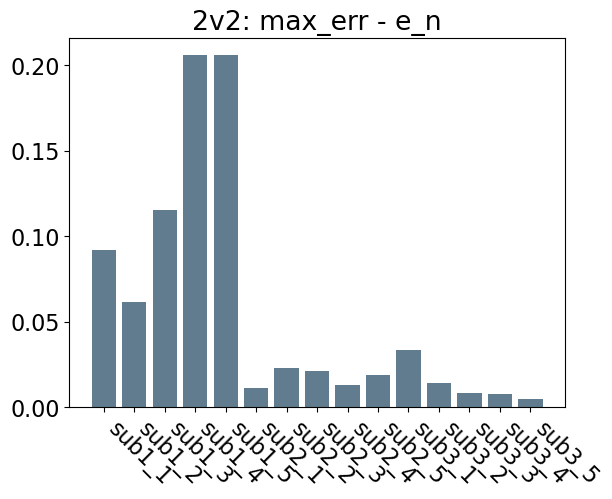

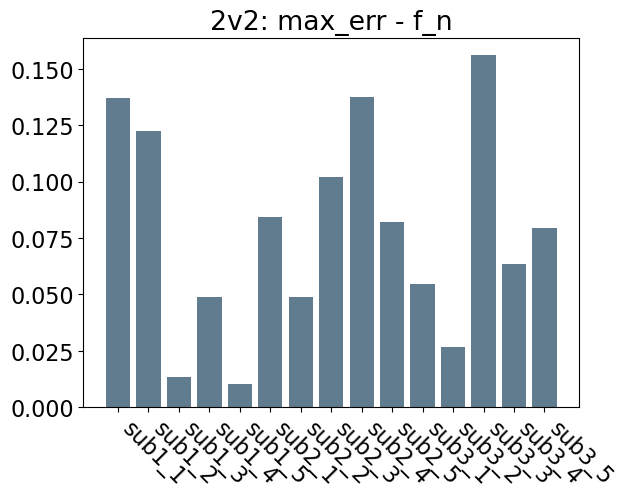

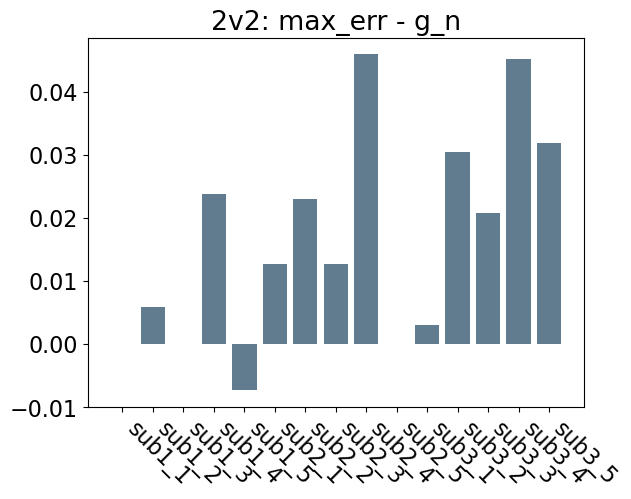

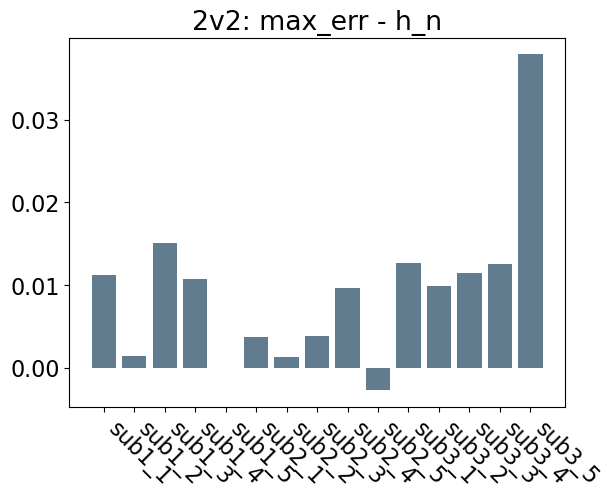

In [7]:
plt_metric_and_directions(:max_err, "xkcd:blue grey")

### Movement Efficiency

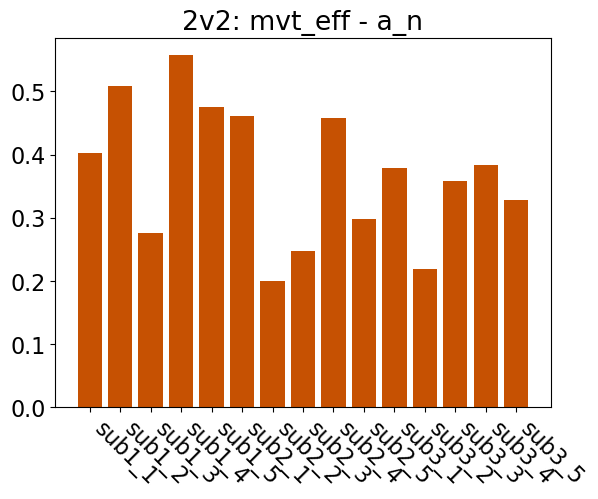

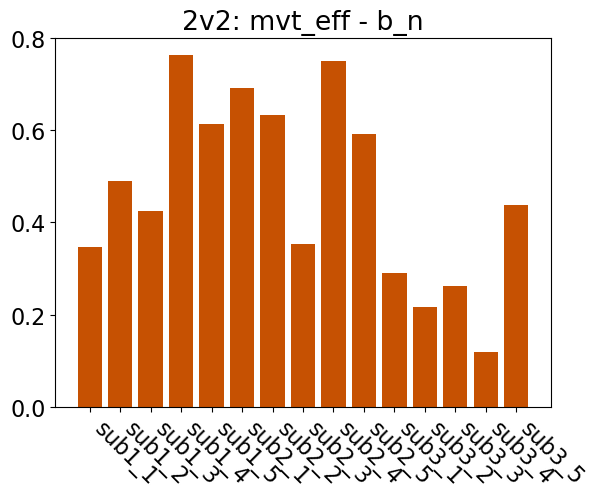

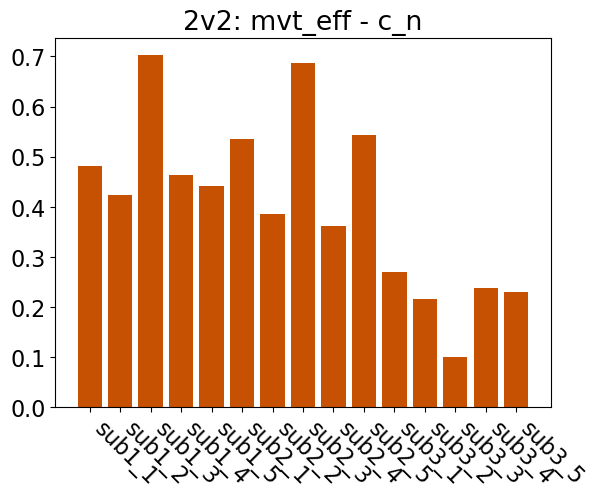

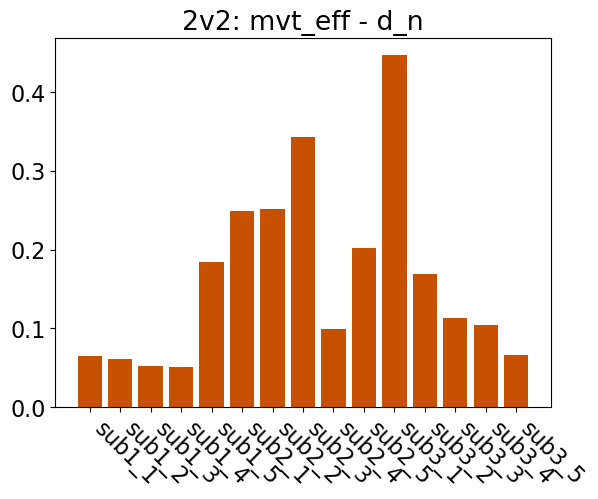

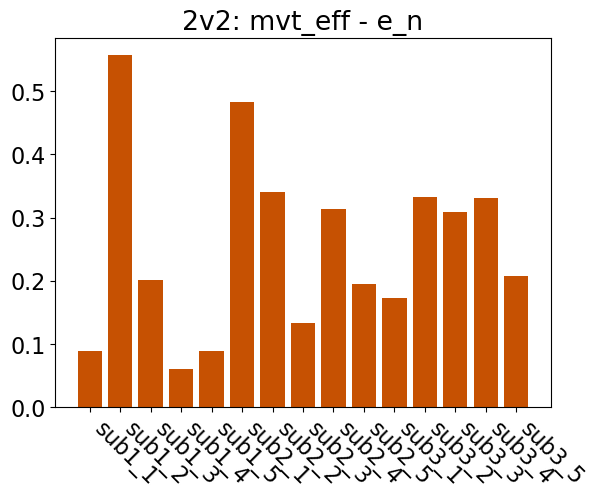

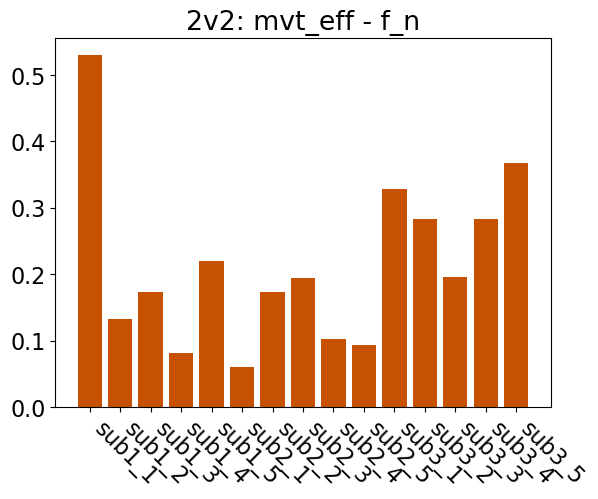

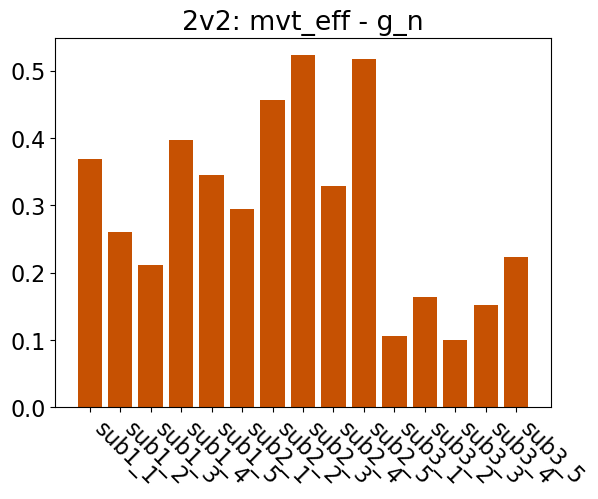

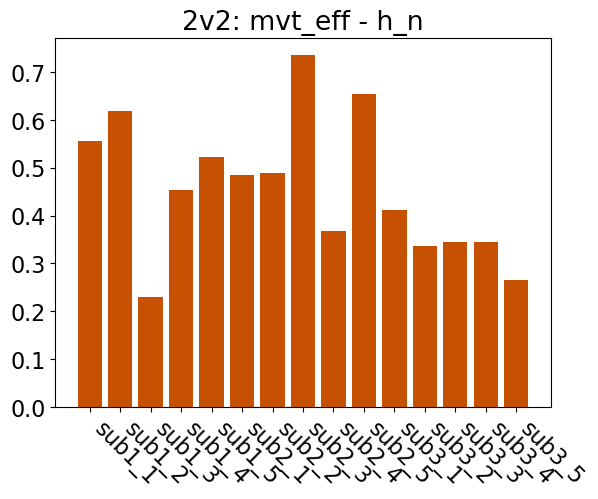

In [8]:
plt_metric_and_directions(:mvt_eff, "xkcd:dark orange")

### Max Area Region

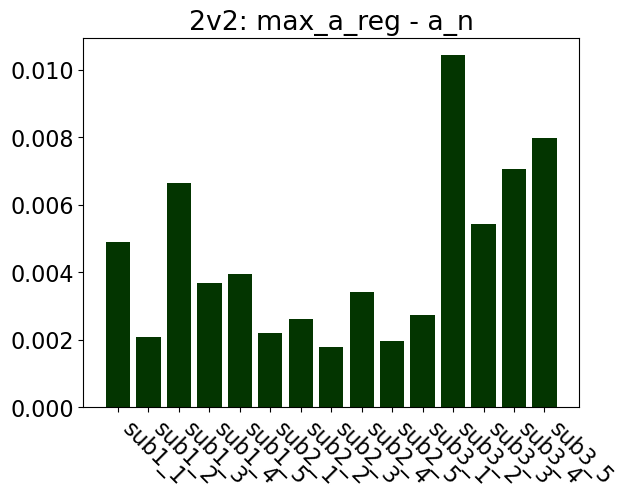

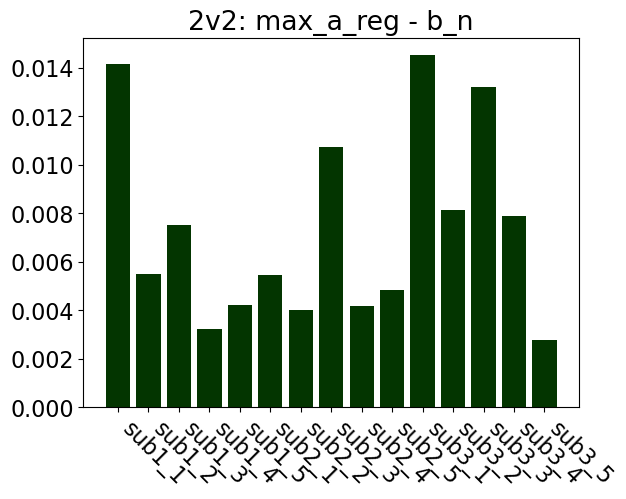

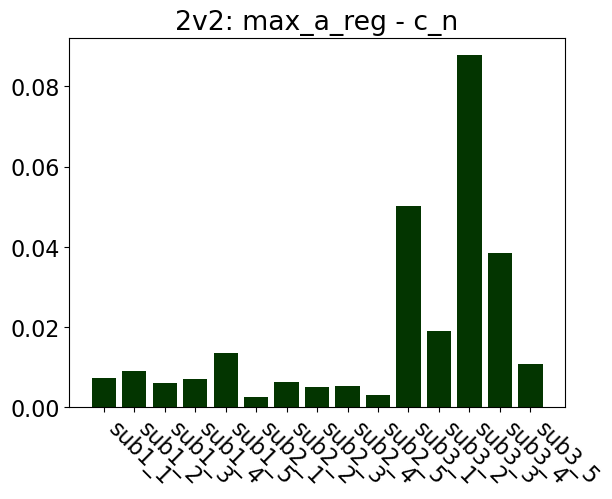

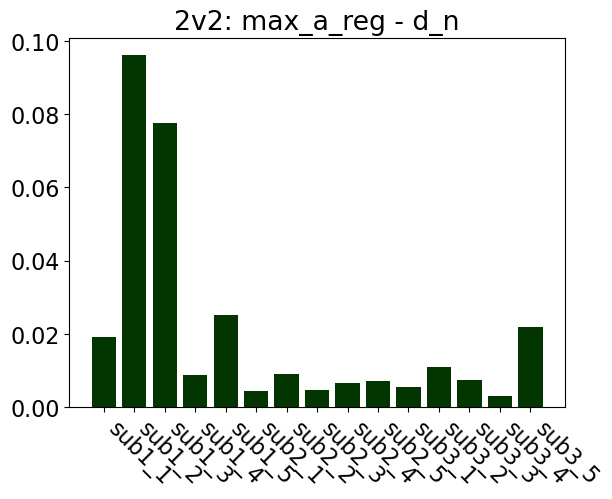

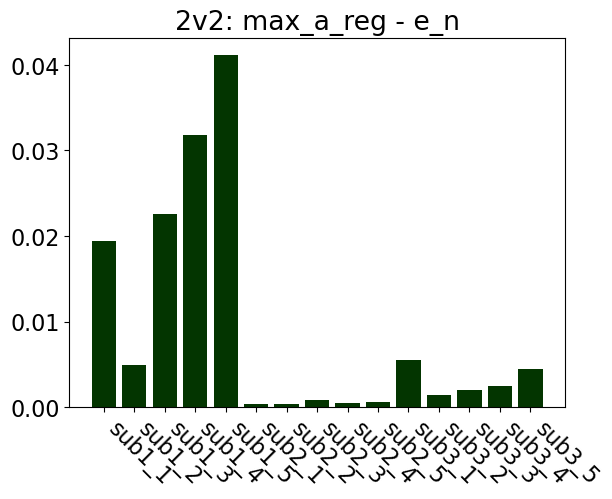

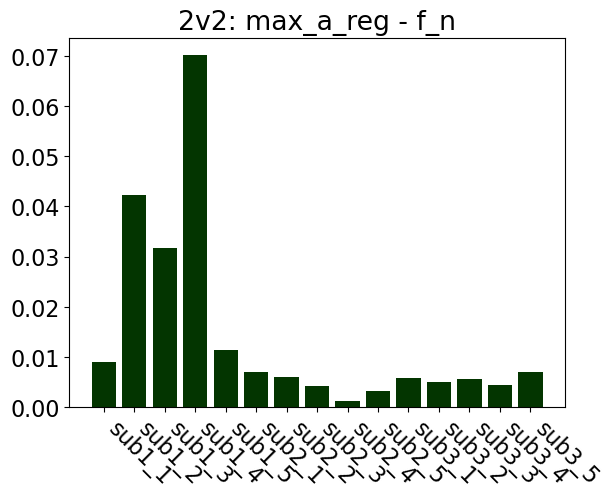

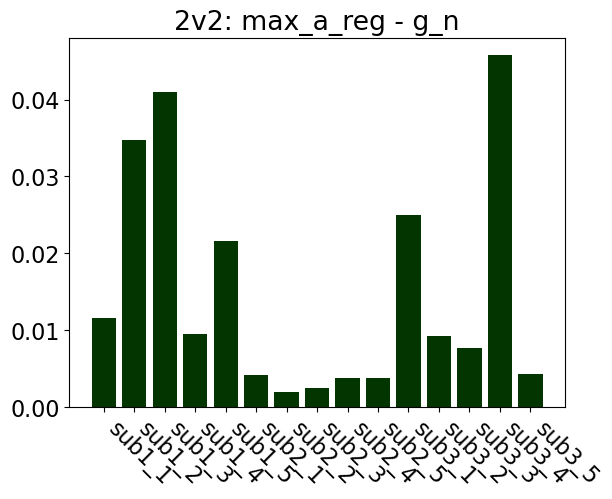

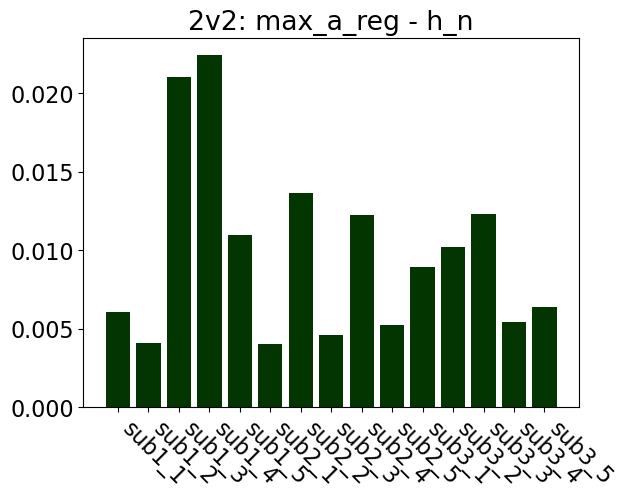

In [9]:
plt_metric_and_directions(:max_a_reg, "xkcd:dark green")

### Max Area Region Location

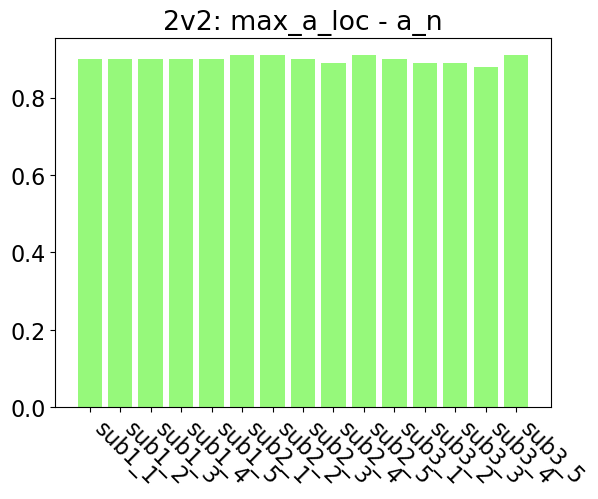

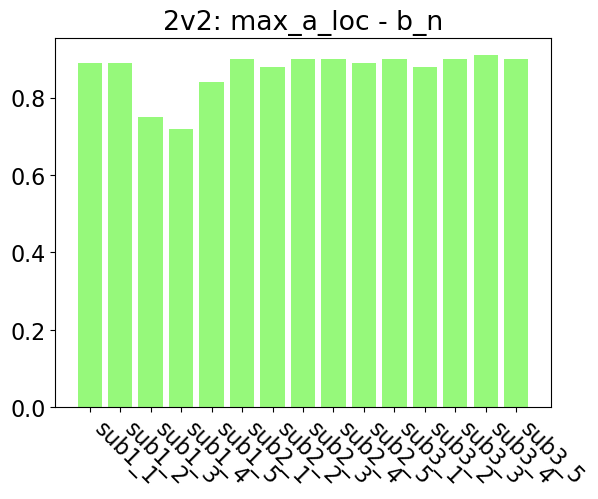

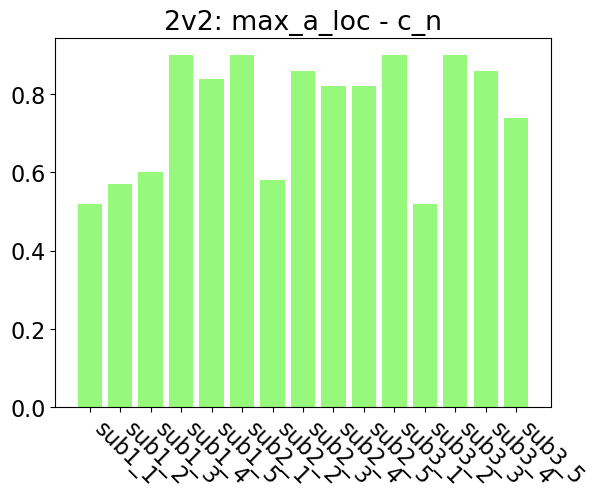

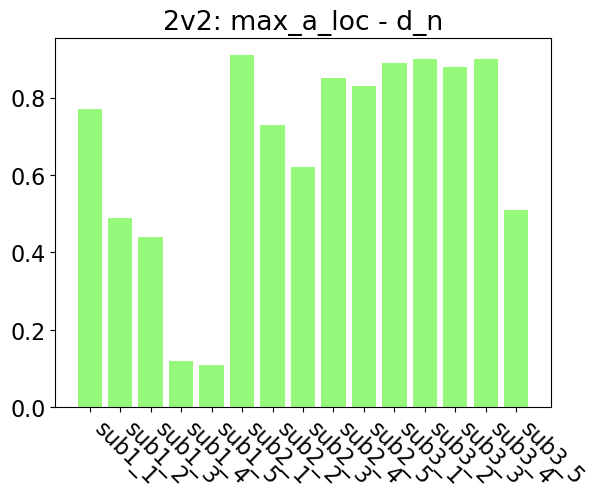

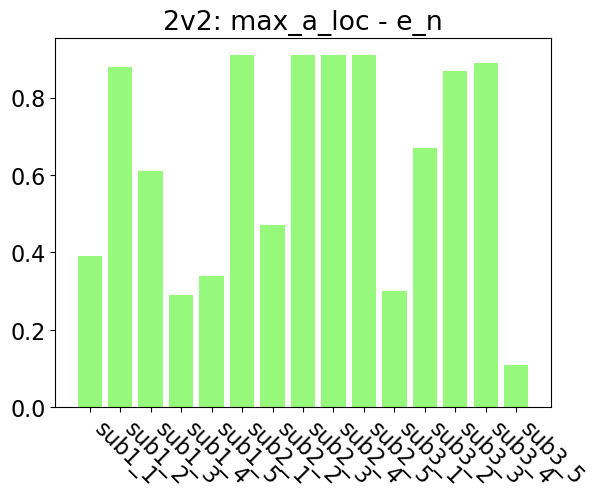

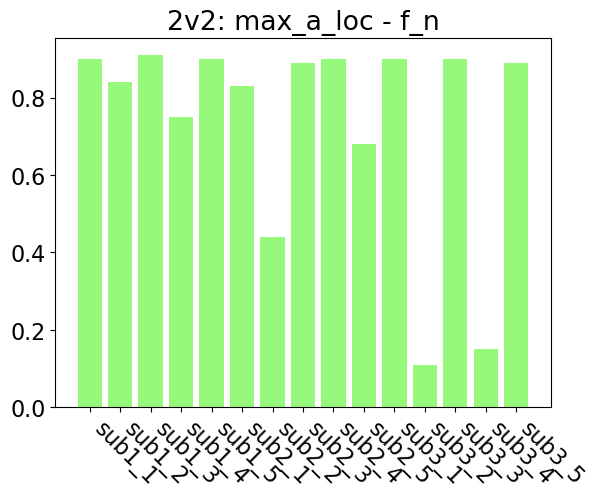

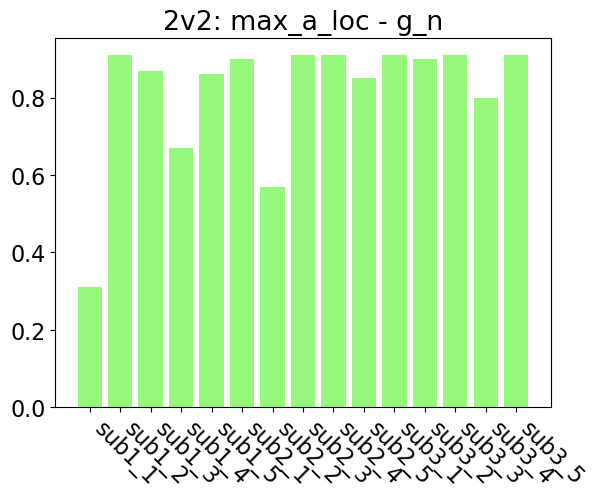

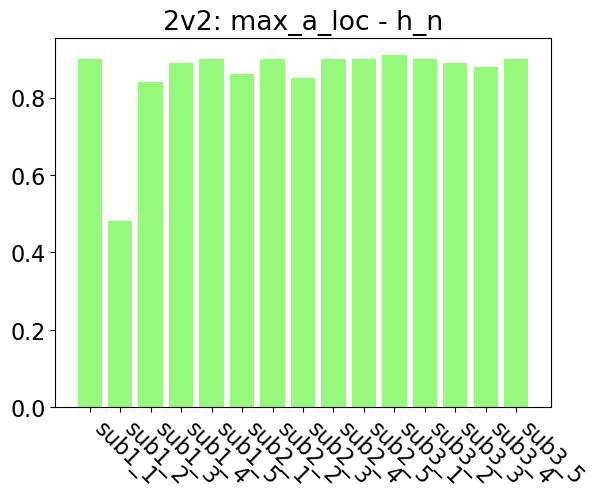

In [10]:
plt_metric_and_directions(:max_a_loc, "xkcd:light green")

### Translational Frechet Distance

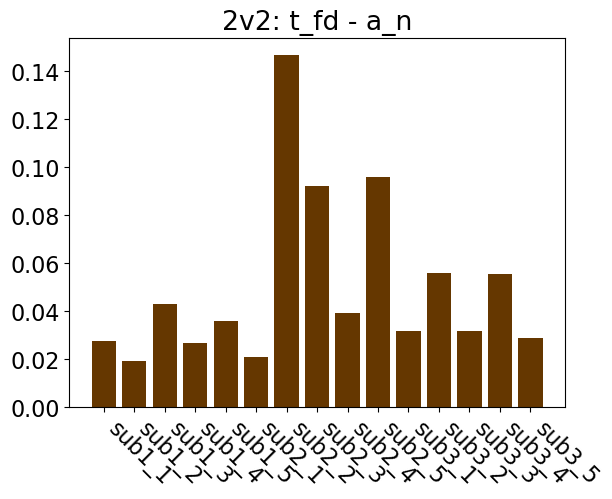

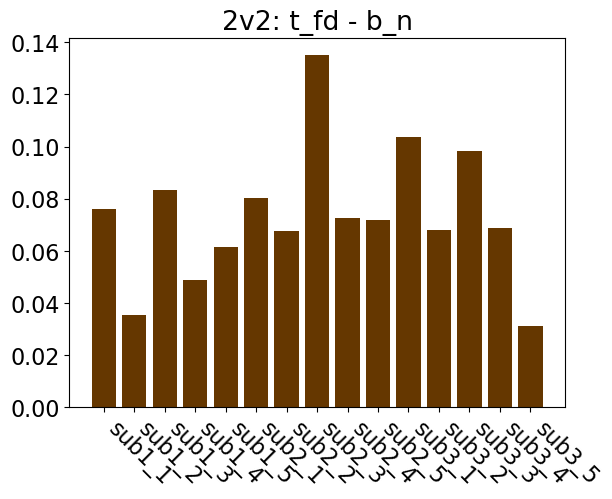

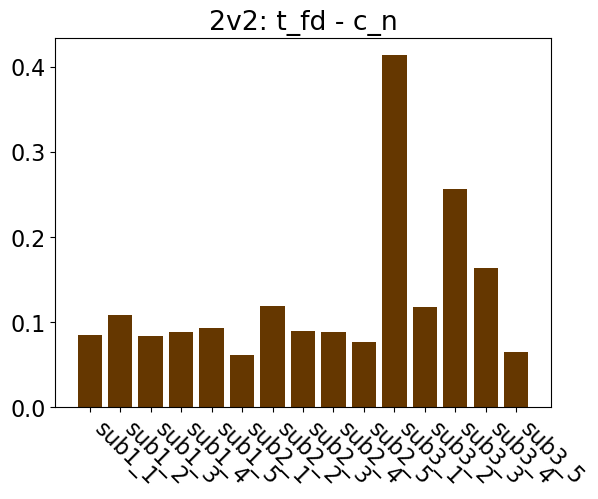

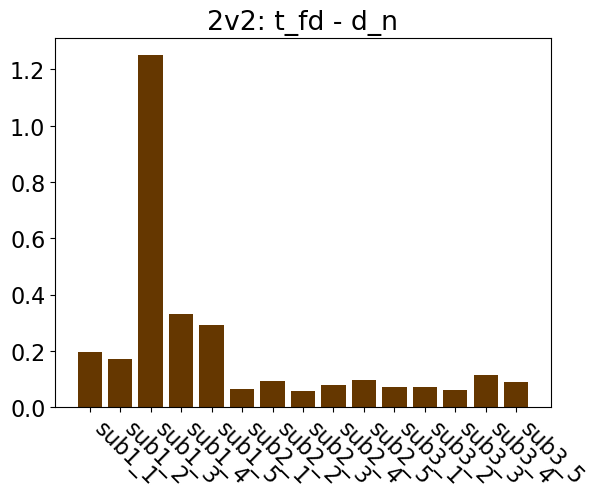

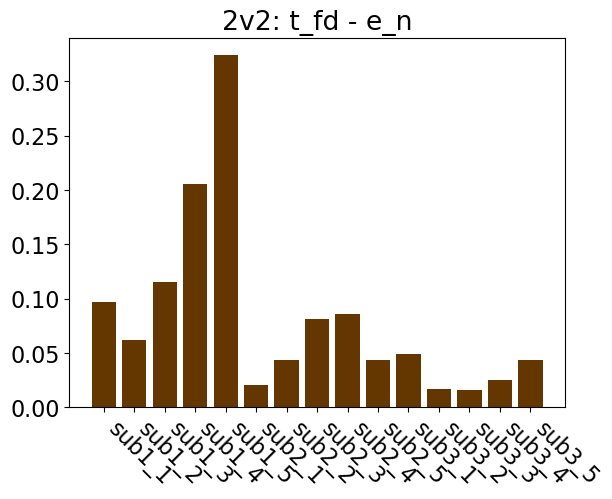

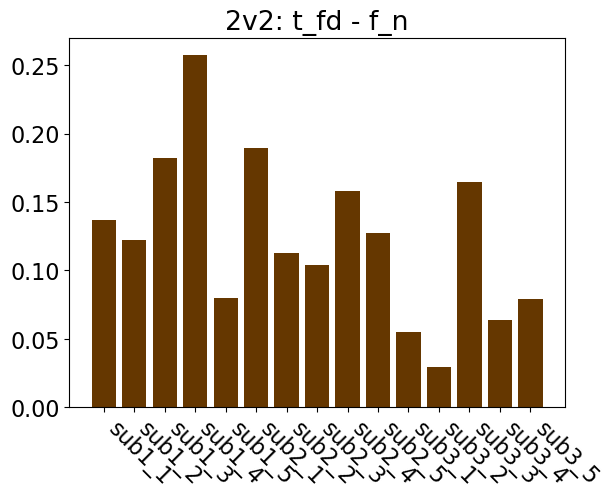

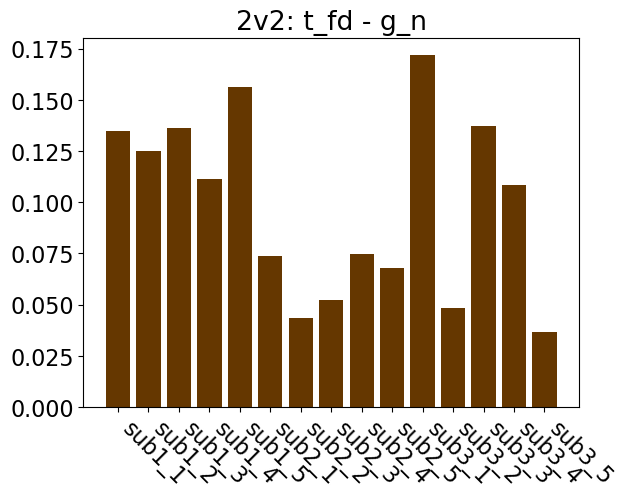

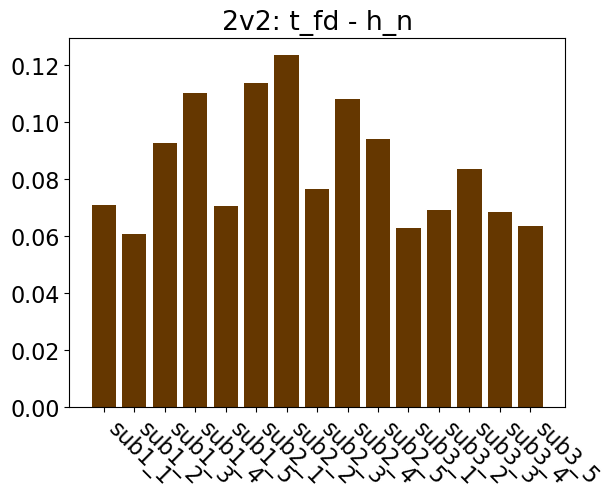

In [11]:
plt_metric_and_directions(:t_fd, "xkcd:brown")

### Rotational Frechet Distance

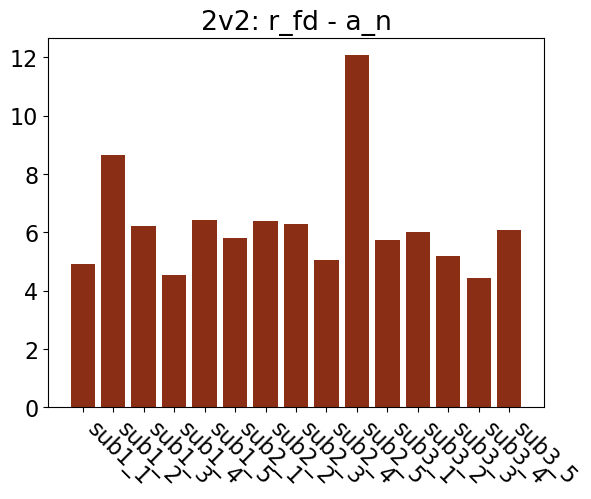

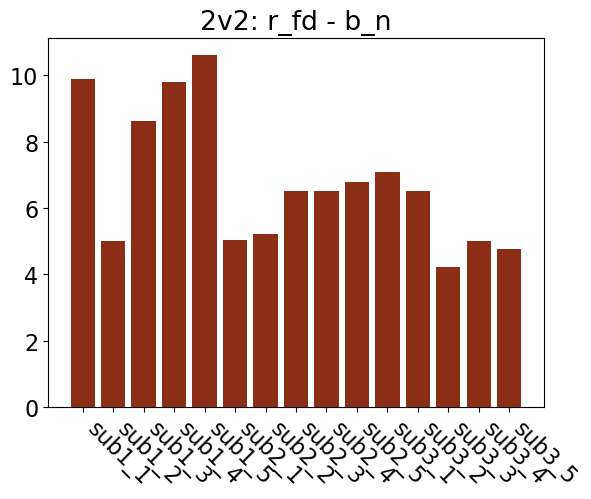

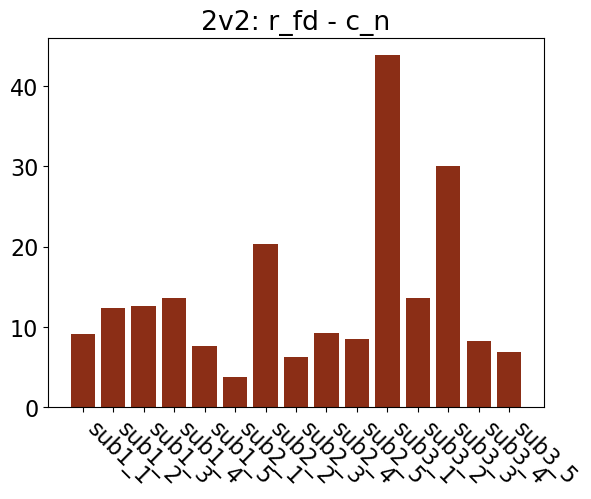

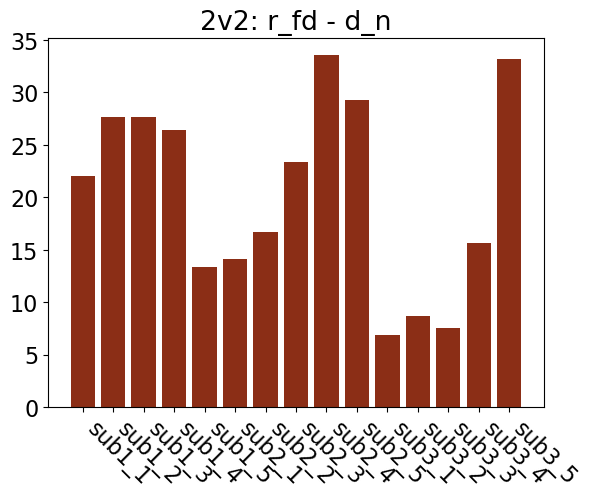

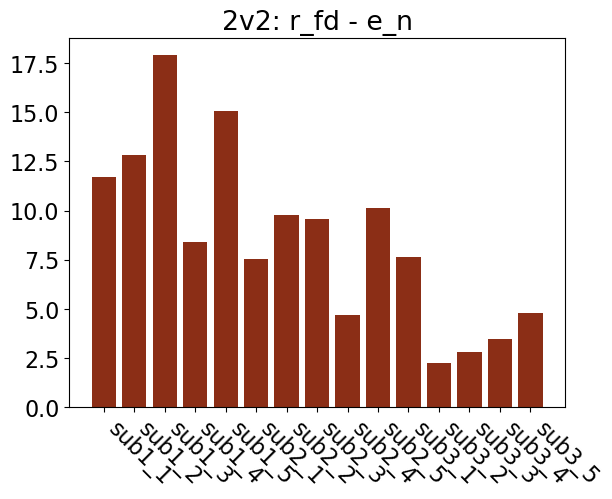

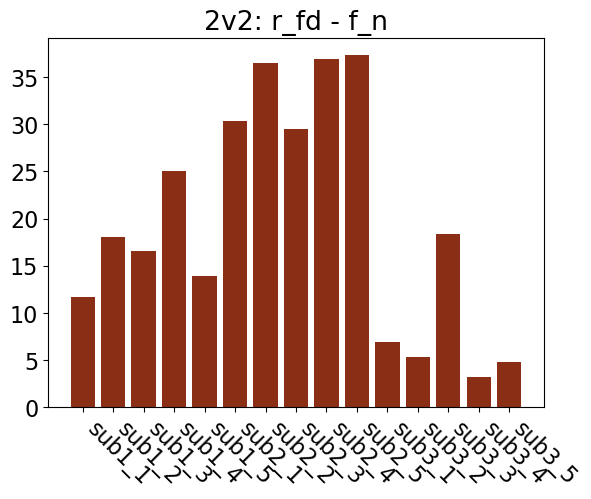

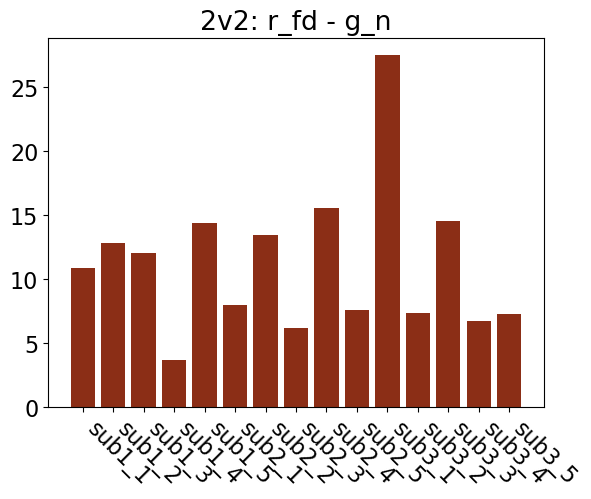

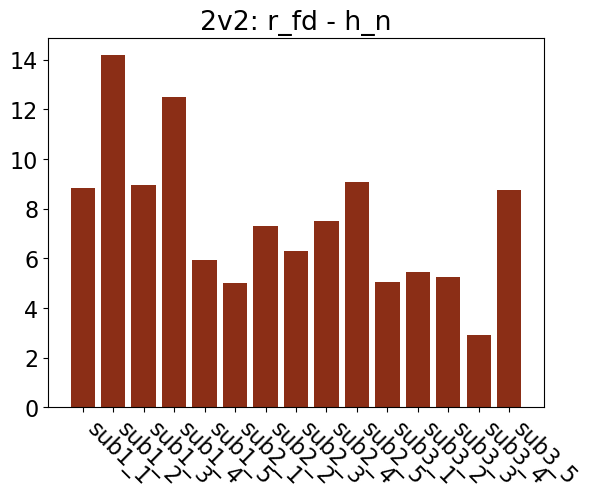

In [12]:
plt_metric_and_directions(:r_fd, "xkcd:red brown")

## Observations
Here is what I see based on the above plots.

-----

# Average Line Calculations

#### Dir: A
![Average Debug Plot for direction A](./pics/avgdebug_2v2_3subs_a_n.jpg)

#### Dir: B
![Average Debug Plot for direction B](./pics/avgdebug_2v2_3subs_b_n.jpg)

#### Dir: C
![Average Debug Plot for direction C](./pics/avgdebug_2v2_3subs_c_n.jpg)

#### Dir: D
![Average Debug Plot for direction D](./pics/avgdebug_2v2_3subs_d_n.jpg)

#### Dir: E
![Average Debug Plot for direction E](./pics/avgdebug_2v2_3subs_e_n.jpg)

#### Dir: F
![Average Debug Plot for direction F](./pics/avgdebug_2v2_3subs_f_n.jpg)

#### Dir: G
![Average Debug Plot for direction G](./pics/avgdebug_2v2_3subs_g_n.jpg)

#### Dir: H
![Average Debug Plot for direction H](./pics/avgdebug_2v2_3subs_h_n.jpg)


----

# T Tests for Symmetry

In [42]:
using HypothesisTests
# find average p-value between each trial in each direction. To get a baseline pvalue to base it on
metric = :arc_len


function analyze_pvals(m::Symbol)
    translations = ["a", "b", "c", "d", "e", "f", "g", "h"]
    pvalues = []

    for t in translations
        # get values of trials with the same direction
        vv, _ = get_trial_vals(df_2v2, m, t)
        #v = convert(Array{Float64,1}, vals)

        # calculate pvalue for the set
        p_val = pvalue(OneSampleTTest(vv))

        # put pvalue into a list of pvalues
        # calculate average and std
        # print it all out
        push!(pvalues, p_val)
    end
    
    println(pvalues)

    avg_pval = mean(pvalues)
    std_pval = std(pvalues)
    
    println("  ")
    println(f"average: {avg_pval}, std: {std_pval}")
    return avg_pval, std_pval, pvalues
end

analyze_pvals(metric)

Any[2.320386972929828e-9, 4.751850981516723e-6, 0.00012885819264938123, 0.00027442064166007576, 0.001133028028139548, 2.0199910510964054e-5, 1.8781162664644526e-5, 4.2415235590336695e-7]
  
average: 0.00019755828241862583, std: 0.0003899107890216222


(0.00019755828241862583, 0.0003899107890216222, Any[2.320386972929828e-9, 4.751850981516723e-6, 0.00012885819264938123, 0.00027442064166007576, 0.001133028028139548, 2.0199910510964054e-5, 1.8781162664644526e-5, 4.2415235590336695e-7])

In [53]:
function compare_2_directions(metric::Symbol)
    translations = ["a", "b", "c", "d", "e", "f", "g", "h"]
    results_report = zeros(8, 8)
    
    for t in translations
        i = findall(x->x==t, translations)[1]
        n = 0
        
        for t2 in translations[i:end]
            v1, _ = get_trial_vals(df_2v2, metric, t)
            v2, _ = get_trial_vals(df_2v2, metric, t2)
            
            #v1 = convert(Array{Float64,1}, vals1)
            #v2 = convert(Array{Float64,1}, vals2)
            
            result = pvalue(OneSampleTTest(v1, v2))
            r = round(result, digits=4)
            results_report[i, i+n] = r
            
            # println(f" For {t} v {t2}: {r}")
            n = n+1
        end
        println(" ")
    end
    
    r_df = DataFrame(trials=translations = ["a", "b", "c", "d", "e", "f", "g", "h"], 
                     a=results_report[1,:], b=results_report[2,:], c=results_report[3,:],
                     d=results_report[4,:], e=results_report[5,:], f=results_report[6,:],
                     g=results_report[7,:], h=results_report[8,:])
    
    return r_df
end





compare_2_directions (generic function with 1 method)

In [85]:
for m in metrics
    maxes = []
    mins = []
    r = compare_2_directions(m)
    
#     for row in eachrow(r)
#         println(row)
#         a = filter(!isnan,row)
#         aa = filter(x->x!=0,a)
#         max = maximum(aa)
#         min = minimum(aa)
#         push!(maxes, max)
#         push!(mins, min)
    #     end
#     results_df = compare_2_directions(m)
#     a = filter(!isnan,results_df[1, :b])
#     aa = filter(x->x!=0,a)
    
    # filter nans and zeroes, filter the rows
    # print maximum and minimums for each row

    
    println(f"{m} data")
    println("   ")
    println(r)
    println("================================================")
    # println("    ")
    # println("Max Values")
    # println(f"a: {maxes[1]}, b: {maxes[2]}, c: {maxes[3]}, d: {maxes[4]}, e: {maxes[5]}, f: {maxes[6]}, g: {maxes[7]}, h: {maxes[8]}")
    # println(maximum(results_df))
    # println("    ")
    # println("Min Values")
    # println(minimum(results_df))
    # println(f"a: {mins[1]}, b: {mins[2]}, c: {mins[3]}, d: {mins[4]}, e: {mins[5]}, f: {mins[6]}, g: {mins[7]}, h: {mins[8]}")
    println("    ")
end

 
 
 
 
 
 
 
 
arc_len data
   
8×9 DataFrame
 Row │ trials  a         b         c         d         e         f         g        h       
     │ String  Float64   Float64   Float64   Float64   Float64   Float64   Float64  Float64 
─────┼──────────────────────────────────────────────────────────────────────────────────────
   1 │ a       NaN         0.0       0.0       0.0       0.0       0.0       0.0        0.0
   2 │ b         0.4631  NaN         0.0       0.0       0.0       0.0       0.0        0.0
   3 │ c         0.5636    0.2129  NaN         0.0       0.0       0.0       0.0        0.0
   4 │ d         0.0105    0.008     0.0228  NaN         0.0       0.0       0.0        0.0
   5 │ e         0.1662    0.1253    0.2961    0.0517  NaN         0.0       0.0        0.0
   6 │ f         0.1092    0.0921    0.3185    0.0285    0.6933  NaN         0.0        0.0
   7 │ g         0.0239    0.0013    0.0253    0.0681    0.876     0.8642  NaN          0.0
   8 │ h         0.1834    0.7

In [103]:
# results_report = zeros(8, 8)
# results_report[4,3] = NaN
# results_report[4,:]

# rr = DataFrame(dir=["a", "b", "c", "d", "e", "f", "g", "h"], a=)

# Clustering for Symmetry

In [16]:
using Clustering

# use kmeans or hierarchical clustering single linkage?

┌ Info: Precompiling Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5]
└ @ Base loading.jl:1278


In [17]:
test = [1, 2, 3, 4, 5]
t = 2
i = findall(x->x!=t, test)

4-element Array{Int64,1}:
 1
 3
 4
 5